<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-de-aprendizaje-ams182/blob/main/TecMty_kmeans_target_A01104775.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [51]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from scipy.spatial.distance import cdist

Importa la base de datos

In [53]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [54]:
df.head()

,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [56]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

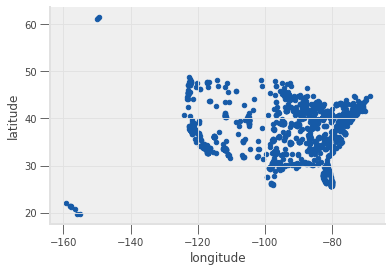

In [57]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [58]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [59]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [60]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()


,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [61]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [62]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [63]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

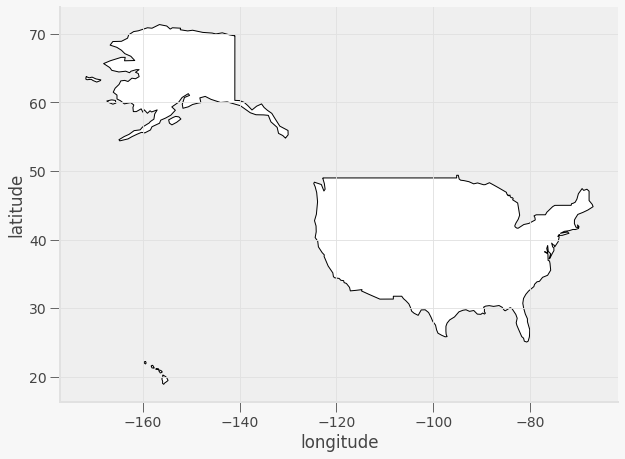

In [64]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

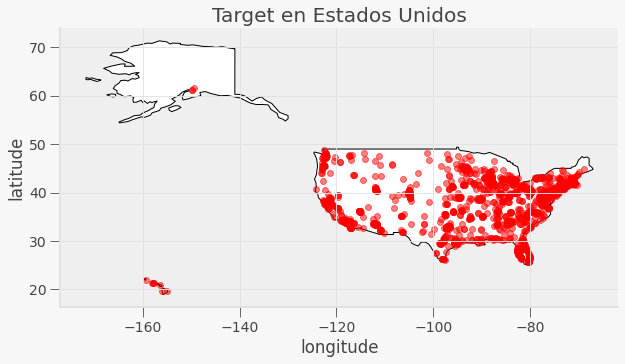

In [65]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

Encuentra el numero ideal de almacenes, justifica tu respuesta:

    Encuentra las latitudes y longitudes de los almacenes, ¿que ciudad es?, ¿a cuantas tiendas va surtir?, ¿sabes a que distancia estara?
    ¿Cómo elegiste el numero de almacenes?, justifica tu respuesta tecnicamente?

Adicionalmente, en el notebook notaras que al inicio exploramos los datos y los graficamos de manera simple, despues nos auxiliamos de una librería de datos geograficos.

    ¿qué librerías nos pueden ayudar a graficar este tipo de datos?
    ¿Consideras importante que se grafique en un mapa?, ¿por qué?

    Agrega las conclusiones


In [66]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df = gpd.GeoDataFrame(df, geometry="Coordinates")
df.rename(columns={"name": "parcelid"}, inplace=True)
df.dropna(axis=0,how='any',subset=['latitude','longitude'],inplace=True)
df.head()

,parcelid,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [67]:
# Variable with the Longitude and Latitude
X=df.loc[:,['parcelid','latitude','longitude']]
X.head(10)

,parcelid,latitude,longitude
0,Alabaster,33.224225,-86.804174
1,Bessemer,33.334550,-86.989778
2,Daphne,30.602875,-87.895932
3,Decatur,34.560148,-86.971559
4,Dothan,31.266061,-85.446422
5,Florence,34.842085,-87.633908
6,Fultondale,33.606040,-86.805557
7,Gulf Shores,30.303980,-87.679995
8,Homewood,33.467142,-86.775100
9,Madison,34.748820,-86.756250


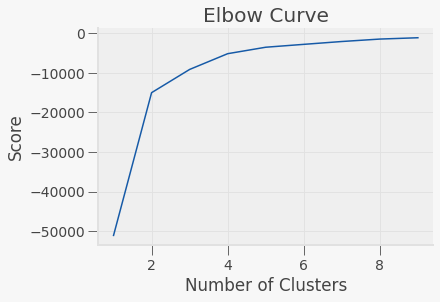

In [68]:
np.random.seed(2)
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df[['latitude']]
X_axis = df[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [69]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
X.head(10)

,parcelid,latitude,longitude,cluster_label
0,Alabaster,33.224225,-86.804174,1
1,Bessemer,33.334550,-86.989778,1
2,Daphne,30.602875,-87.895932,1
3,Decatur,34.560148,-86.971559,1
4,Dothan,31.266061,-85.446422,2
5,Florence,34.842085,-87.633908,1
6,Fultondale,33.606040,-86.805557,1
7,Gulf Shores,30.303980,-87.679995,1
8,Homewood,33.467142,-86.775100,1
9,Madison,34.748820,-86.756250,1


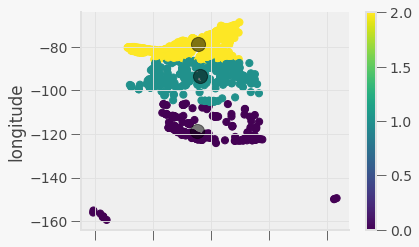

In [70]:
X.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

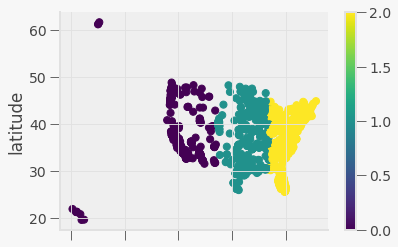

In [71]:
X.plot.scatter(y = 'latitude', x = 'longitude', c=labels, s=50, cmap='viridis')

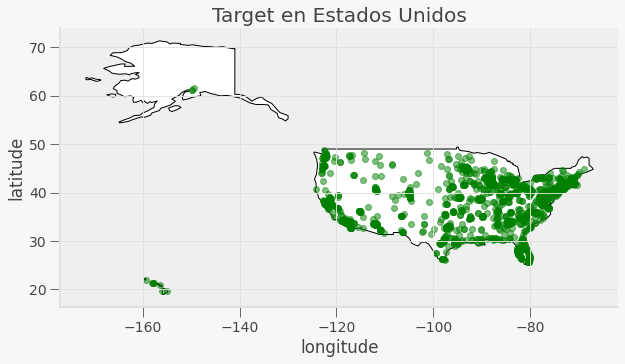

In [72]:
fig, gax = plt.subplots(figsize=(10,10))

world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

gdf.plot(ax=gax, color='green', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

In [73]:
X = X[['parcelid','cluster_label']]
X.head(5)

,parcelid,cluster_label
0,Alabaster,1
1,Bessemer,1
2,Daphne,1
3,Decatur,1
4,Dothan,2


In [74]:
clustered_data = df.merge(X, left_on='parcelid', right_on='parcelid')
clustered_data['state'] = clustered_data['address'].apply(lambda x: (str(x).split(', ')[-1])[0:2])
clustered_data.head(5)

,parcelid,latitude,longitude,address,phone,website,Coordinates,cluster_label,state
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423),1,AL
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455),1,AL
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287),1,AL
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015),1,AL
4,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015),1,AL


In [75]:
centers = kmeans.cluster_centers_
print(centers[0])
print('Round Valley Joint Elementary, California\n')
print(centers[1])
print('Cross Timbers, Misuri\n')
print(centers[2])
print('Scottsville District, Virginia\n')



[  37.48734203 -118.62447332]
Round Valley Joint Elementary, California

[ 37.98791364 -93.27994961]
Cross Timbers, Misuri

[ 37.78260864 -78.5343898 ]
Scottsville District, Virginia



In [76]:
table = pd.pivot_table(clustered_data, values='parcelid', index=['cluster_label'], aggfunc='count')

c0 = clustered_data.loc[clustered_data['cluster_label']== 0]
table_0 = pd.pivot_table(c0 , index=['state'])
ciudades_uno = table_0.index


c1 = clustered_data.loc[clustered_data['cluster_label']== 1]
table_1 = pd.pivot_table(c1, index=['state'])
ciudades_dos = table_1.index

c2 = clustered_data.loc[clustered_data['cluster_label']== 2]
table_2 = pd.pivot_table(c2, index=['state'])
ciudades_tres = table_2.index

print(table)
print('\n')
print(ciudades_uno)
print('\n')
print(ciudades_dos)
print('\n')
print(ciudades_tres)
print('\n')


               parcelid
cluster_label          
0                   411
1                   728
2                   956


Index(['AK', 'AZ', 'CA', 'CO', 'CT', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'MA',
       'MD', 'MN', 'MO', 'MT', 'NC', 'NE', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OR',
       'PA', 'RI', 'TX', 'UT', 'VA', 'WA', 'WY'],
      dtype='object', name='state')


Index(['AL', 'AR', 'AZ', 'CA', 'CO', 'FL', 'GA', 'IA', 'IL', 'IN', 'KS', 'KY',
       'LA', 'MA', 'MD', 'MI', 'MN', 'MO', 'MS', 'NC', 'ND', 'NE', 'NJ', 'NM',
       'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'VA', 'WA',
       'WI', 'WV', 'WY'],
      dtype='object', name='state')


Index(['AL', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'IA', 'IL', 'IN', 'KY',
       'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'NC', 'NE', 'NH', 'NJ', 'NM',
       'NY', 'OH', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'VA', 'VT', 'WA',
       'WV'],
      dtype='object', name='state')




In [77]:
dm = cdist(df[['latitude','longitude']], centers)
dm

array([[32.10460452,  8.03917902,  9.44289063],
       [31.90610655,  7.8243244 ,  9.55399459],
       [31.49030264,  9.13928055, 11.79775598],
       ...,
       [13.47222956, 13.86357297, 28.1884114 ],
       [14.30447485, 11.94937659, 26.48216738],
       [ 9.8577434 , 18.34753079, 32.75257795]])

1. Encuentra el numero ideal de almacenes, justifica tu respuesta: 3, debido a que al usar la gráfica y el método del codo, este se forma en 2 o 3
*********

2. Encuentra las latitudes y longitudes de los almacenes, ¿que ciudad es?

> [ 37.48734203 -118.62447332] Round Valley Joint Elementary, California;

> [ 37.98791364 -93.27994961] Cross Timbers, Misuri; 

> [ 37.78260864 -78.5343898 ] Scottsville District, Virginia; 

*********
3. ¿a cuantas tiendas va surtir?
411, 728 y a 956.
*********
4. ¿sabes a que distancia estara?
a las distancias definidas en dm, manualmente siguiendo la Fórmula del Haversine [2]
*********
5. ¿Cómo elegiste el numero de almacenes?
Haciendo la agrupación de la clasificación del cluster.
*********
6. ¿qué librerías nos pueden ayudar a graficar este tipo de datos?
Arcpy, GDAL/OGR, RSGISLib, PyProj
*********
7. ¿Consideras importante que se grafique en un mapa? Si, ¿por qué? porque permite una mejor idea de como se distribuyen los datos en el mapa.



Conclusiones: 

1. Si quisiera una estrategia expansiva, buscaria enfocar los esfuerzon en el almacen que suministre a los estados: 'AK', 'AZ', 'CA', 'CO', 'CT', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'MA', 'MD', 'MN', 'MO', 'MT', 'NC', 'NE', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OR', 'PA', 'RI', 'TX', 'UT', 'VA', 'WA', 'WY'.
2. En caso de una estrategia de retención: 'AL', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'IA', 'IL', 'IN', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'NC', 'NE', 'NH', 'NJ', 'NM', 'NY', 'OH', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'VA', 'VT', 'WA','WV'.
3. Bajo el supuesto de que 3 almacenes son posibles, el de mayor importancia seria  [ 37.78260864 -78.5343898 ] Scottsville District, Virginia.
4. Vale la pena ampliar el estudio para el caso de mas de 3 almacenes.





Funetes:

1. Magiya J. (2019), gitconnected, recuperado el 07/11/2022 de: https://levelup.gitconnected.com/clustering-gps-co-ordinates-forming-regions-4f50caa7e4a1

2. José M. (2011), Gembeta, recuperado el 07/11/2022 de:https://www.genbeta.com/desarrollo/como-calcular-la-distancia-entre-dos-puntos-geograficos-en-c-formula-de-haversine